In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd

from matplotlib import pyplot

## TODO:

- check for information leakage/over fitting etc
- hyperparameter tuning
- more features
- feature importances
- combine prime/opt team results  for round predictor

In [3]:
df = pd.read_parquet('../data/raw/features.parquet', use_pandas_metadata=True)
df.columns

Index(['season', 'round', 'venue', 'date', 'prime_team', 'prime_team_points',
       'opt_team', 'opt_team_points', 'home_away', 'prime_margin', 'result',
       'prime_margin_1', 'prime_margin_2', 'prime_margin_3', 'prime_margin_4',
       'prime_margin_5', 'prime_margin_6', 'pm_l6w'],
      dtype='object')

In [4]:
df.head()

,season,round,venue,date,prime_team,prime_team_points,opt_team,opt_team_points,home_away,prime_margin,result,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w
0,2018,25,"Stadium Australia, Sydney",2018-08-30,Rabbitohs,51.0,Wests Tigers,10.0,home,41.0,1.0,-12.0,-20.0,-4.0,10.0,6.0,-16.0,-6.000000
1,2018,25,"Mt Smart Stadium, Auckland",2018-08-31,Warriors,20.0,Raiders,16.0,home,4.0,1.0,20.0,-1.0,16.0,6.0,-24.0,-6.0,1.833333
2,2018,25,"AAMI Park, Melbourne",2018-08-31,Storm,16.0,Panthers,22.0,home,-6.0,-1.0,2.0,16.0,-3.0,-10.0,34.0,6.0,7.500000
3,2018,25,"McDonald Jones Stadium, Newcastle",2018-09-01,Knights,14.0,Dragons,24.0,home,-10.0,-1.0,-26.0,8.0,-16.0,-9.0,-2.0,6.0,-6.500000
4,2018,25,"Cbus Super Stadium, Gold Coast",2018-09-01,Titans,26.0,Cowboys,30.0,home,-4.0,-1.0,-2.0,8.0,-1.0,-16.0,24.0,-6.0,1.166667


In [5]:
y_cols = 'result'
X_cols = ['prime_team', 'home_away', 'opt_team', 'venue', 'prime_margin_1', 'prime_margin_2', 'prime_margin_3', 
          'prime_margin_4', 'prime_margin_5', 'prime_margin_6', 'pm_l6w']

In [6]:
history_df=df.loc[(df.result!=0) & ~df.result.isna(), :] # drop out the two draws, we're not trying to predict those so lets keep this binary
categories = {-1: 0, 1:1}

In [7]:
X_df = history_df.loc[:, X_cols]
y_df = history_df.loc[:, y_cols]
y_df = y_df.replace(categories)

In [8]:
seed = 10
test_size = 0.33

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_size, random_state=seed)
#eval_set = [(X_test, y_test)]
eval_set = [(X_train, y_train), (X_test,y_test)]

In [9]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
clf = XGBClassifier(tree_method="gpu_hist", 
                    #booster='dart',
                    enable_categorical=True, 
                    eval_metric="error",
                    early_stopping_rounds=10, 
                    n_estimators=500, 
                    learning_rate=0.05, 
                    gamma=6,
                    eta=0.3,
                    max_depth=30)
# X is the dataframe we created in previous snippet
clf.fit(X_train, y_train,  
        eval_set=eval_set, 
        verbose=True, )

[0]	validation_0-error:0.25645	validation_1-error:0.35131
[1]	validation_0-error:0.23306	validation_1-error:0.35948
[2]	validation_0-error:0.23952	validation_1-error:0.35948
[3]	validation_0-error:0.22581	validation_1-error:0.35621
[4]	validation_0-error:0.22661	validation_1-error:0.35621
[5]	validation_0-error:0.21532	validation_1-error:0.35458
[6]	validation_0-error:0.21532	validation_1-error:0.35458
[7]	validation_0-error:0.21371	validation_1-error:0.35458
[8]	validation_0-error:0.21694	validation_1-error:0.34641
[9]	validation_0-error:0.21774	validation_1-error:0.34967
[10]	validation_0-error:0.21935	validation_1-error:0.33987
[11]	validation_0-error:0.21290	validation_1-error:0.34804
[12]	validation_0-error:0.21452	validation_1-error:0.34804
[13]	validation_0-error:0.21371	validation_1-error:0.34314
[14]	validation_0-error:0.21371	validation_1-error:0.35458
[15]	validation_0-error:0.21774	validation_1-error:0.35458
[16]	validation_0-error:0.21774	validation_1-error:0.35294
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=True, eta=0.3,
              eval_metric='error', feature_types=None, gamma=6, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=30, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [10]:
predictions = clf.predict(X_test)

In [11]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.01%


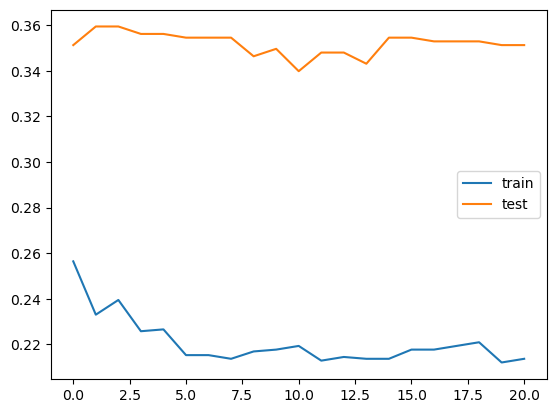

In [12]:
results = clf.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['error'], label='train')
pyplot.plot(results['validation_1']['error'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [13]:
nr_pred=clf.predict(df.loc[(df.season==2023) & 
                   (df['round']==1), X_cols])

In [14]:
next_round = df.loc[(df.season==2023) & 
       (df['round']==1), X_cols]

In [15]:
next_round.assign(pred = nr_pred)

,prime_team,home_away,opt_team,venue,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w,pred
1124,Eels,home,Storm,"CommBank Stadium, Sydney",8.0,47.0,36.0,-26.0,16.0,24.0,17.500000,1
1125,Warriors,home,Knights,"Sky Stadium, Wellington",-1.0,-34.0,-44.0,24.0,-38.0,-12.0,-17.500000,1
1126,Panthers,home,Broncos,"BlueBet Stadium, Penrith",-30.0,34.0,4.0,-16.0,20.0,-24.0,-2.000000,1
1127,Sea Eagles,home,Bulldogs,"4 Pines Park, Sydney",-1.0,-42.0,-34.0,-20.0,-16.0,-10.0,-20.500000,0
1128,Cowboys,home,Raiders,"Queensland Country Bank Stadium, Townsville",30.0,-10.0,44.0,-14.0,14.0,26.0,15.000000,0
1129,Sharks,home,Rabbitohs,"PointsBet Stadium, Sydney",22.0,16.0,34.0,24.0,6.0,1.0,17.166667,0
1130,Dolphins,home,Roosters,"Suncorp Stadium, Brisbane",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1131,Wests Tigers,home,Titans,"Leichhardt Oval, Sydney",-46.0,-2.0,-66.0,-24.0,-4.0,14.0,-21.333333,0
2256,Storm,away,Eels,"CommBank Stadium, Sydney",-8.0,-4.0,48.0,16.0,18.0,12.0,13.666667,1
2257,Knights,away,Warriors,"Sky Stadium, Wellington",-22.0,-10.0,-6.0,-18.0,4.0,-14.0,-11.000000,0
